# 1 Data Modeling and Analysis

This project perform multiple levels of analysis on the [IMDB](https://data.world/popculture/imdb-5000-movie-dataset)/[TMDB](https://www.kaggle.com/tmdb/tmdb-movie-metadata) datasets. 

This file contains preliminary data analysis on the categorical and numerical features of those two datasets. We explore the types of movies that are successful by genre, year, and other metrics. Further analysis of categorical variables may be found in `2. Factors in Film Success.ipynb`.

As our target variable, it is discovered that the `log profit margin` = `log (profit / budget)`, which we call `log_rev_rate` internally, is a suitable metric for financial predictions, as it is not trivially correlated with `budget`. 

In [930]:
%matplotlib inline  
import sys
import pandas as pd
import datetime as dt
import ast
import numpy as np
import math
import datetime
from time import time
from pprint import pprint
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings(action='ignore')

Setting up function options and function tools.

In [931]:
pd.options.display.float_format = '{:.2f}'.format
sns.set(color_codes=True)
mlb = MultiLabelBinarizer()
data_path = "data/"

#### Utility Functions

In [ ]:
def p(x):
    print(x)

def safe_add(dict_,key,x):
    if key not in dict_.keys():
        dict_[key] = 0 
    dict_[key] += x

#Get most common keywords
def get_most_common_with_counts(key, count, df = m):
    most_common_keywords = sorted(Counter([a for b in df[key] for a in b]).items(), key = lambda kv: kv[1], reverse=True)
    return most_common_keywords[:count]
    

def get_most_common(key, count, df = m):
    most_common_keywords = sorted(Counter([a for b in df[key] for a in b]).items(), key = lambda kv: kv[1], reverse=True)
    most_common_keywords = most_common_keywords[:count]
    most_common_keywords = [a for a,b in most_common_keywords]
    return most_common_keywords

# Setup

Reads in the TMDB Credits and Movies files.

In [975]:
c,tmdb = [pd.read_csv(data_path + f, sep=",") for f in ["tmdb_5000_credits.tsv", "tmdb_5000_movies.tsv"]]
tmdb = tmdb.drop(["homepage","status"], axis=1)
print("Num movies before duplicate removal: ", len(tmdb))
tmdb.drop_duplicates(inplace=True)
print("Num movies after duplicate removal: ", len(tmdb))
entities = {}
list_categories = ["genres", "keywords", "production_companies", "production_countries", "spoken_languages"]
for col in list_categories:
    tmdb[col] = pd.Series([[a["name"] for a in ast.literal_eval(b)] for b in tmdb[col]])
    entities[col] = list(set([b for a in tmdb[col] for b in a]))

('Num movies before duplicate removal: ', 4803)
('Num movies after duplicate removal: ', 4803)


Reads in the IMDB Movies metadata file and joins it to the tmdb movie info file.
Almost all data (4803/5043) is retained on an inner join,
and we expect popular and important movies to be in both datasets anyways,
so we use the complete inner-joined dataset.

In [976]:
imdb= pd.read_csv(data_path + "movie_metadata.tsv", sep=",")
print("Num movies before duplicate removal: ", len(imdb))
imdb.drop_duplicates(inplace=True)
print("Num movies after duplicate removal: ", len(imdb))
imdb["movie_title"] = imdb["movie_title"].apply(lambda x: x[0:-2])
imdb = imdb.set_index("movie_title")

m = tmdb.copy()
m["original_title"] = m["original_title"].apply(lambda x: x.strip())
m = m.set_index("original_title")

inner_j = m.join(imdb, how="inner", lsuffix='_t', rsuffix='_i',)
outer_j = m.join(imdb, how="outer", lsuffix='_t', rsuffix='_i',)
print(len(inner_j), len(outer_j))

inner_j = inner_j.drop(["budget_i","gross", "genres_i"], axis = 1)
inner_j = inner_j.rename(columns = {"budget_t":"budget", "genres_t":"genres"})
m = inner_j.reset_index().rename(columns = {"index":"original_title"})

m.drop_duplicates(subset="id",inplace=True)
m_orig = m.copy()

('Num movies before duplicate removal: ', 5043)
('Num movies after duplicate removal: ', 4998)
(4467, 5416)


### Filtering for Medium-High Budget Films

We now filter out movies that have low or missing budget or revenue information, and calcualte profits and return rates. We use 2900 movies which had a budget of over $1 million.

In [977]:
print("Num movies before filtering for high budget/revenue: ", len(m))
m = m[(m.budget >1000000) &  (m.revenue >0)]
m["profit"] = m.revenue - m.budget
m["ret_rate"] = m.profit / m.budget
m["rev_rate"] = m.revenue / m.budget
m["log_rev_rate"] = m["rev_rate"].apply(lambda x: math.log(x))
m["log_budget"] = m["budget"].apply(lambda x: math.log(x))
print("Num movies after filtering for high budget/revenue: ", len(m))
m["log_revenue"] = m.revenue.apply(math.log)
m["Profitable"] = m.revenue > m.budget

('Num movies before filtering for high budget/revenue: ', 4388)
('Num movies after filtering for high budget/revenue: ', 2907)


### Data Cleaning

We clean the data and save it to csv.

In [935]:
m.genres = m.genres.apply(lambda x: [a for a in x if a not in ["Foreign", "Documentary"]])
m.plot_keywords = m.plot_keywords.apply(lambda x: x.split("|") if isinstance(x, str) else [])
m["all_keywords"] = m.plot_keywords + m.keywords
m.all_keywords = m.all_keywords.apply(lambda x: list(set(x)))
m.release_date = m.release_date.apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d"))
m["lang_en"] = m["original_language"] == "en"
numerics = ["budget", "revenue", 'profit', "popularity", "vote_count", "imdb_score"]
m.to_csv(data_path + "movies_postprocessing.csv")

# Data Exploration

## Categorical Variables

How many of each categorical variable is there?

In [936]:
{k:len(v) for k,v in entities.items()}

{'genres': 20,
 'keywords': 9813,
 'production_companies': 5017,
 'production_countries': 88,
 'spoken_languages': 62}

English Movies to Total Number of Movies

In [938]:
sum(m["lang_en"]), len(m)

(2879, 2907)

Below we analyze the correlation between numeric variables in the dataset. We discover budget and Revenue are correlated, and that is in turn correlated with view popularity on TMDB and number of votes. However, correlation with movie runtime and the average number of votes recieved is quite low. We suspect the low correlation with average number of votes received is due to sample size and will be correlated if we restrict to movies with many votes.

### Categorical Variables: Analysis of Genres
Now we analyze the distribution of genres.

In [941]:
#Getting the co-currence count between genres
genres = entities["genres"]
co_occur = {k: [0] * len(genres) for k in genres}
co_occur_df = pd.DataFrame.from_dict(co_occur, orient='index')
co_occur_df.columns=genres
co_occur_list = m_orig["genres"]
genre_counts = {}
for row in co_occur_list:
    for x in row:
        safe_add(genre_counts,x,1)
        for y in row:
            if x!=y:
                co_occur_df[x][y] += 1

What are the most popular genres?

In [943]:
popular_genres = sorted(genre_counts.items(), key=lambda kv: kv[1], reverse=True)
popular_genres = [k for k,v in popular_genres[:10]]
print("All genres: ", sorted(genre_counts.items(), key=lambda kv: kv[1], reverse=True))
print("\n\nPopular Genres :", popular_genres)

('All genres: ', [('Drama', 2078), ('Comedy', 1602), ('Thriller', 1194), ('Action', 1064), ('Romance', 828), ('Adventure', 729), ('Crime', 646), ('Science Fiction', 496), ('Horror', 478), ('Family', 469), ('Fantasy', 389), ('Mystery', 326), ('Animation', 197), ('Music', 172), ('History', 161), ('War', 120), ('Documentary', 95), ('Western', 75), ('Foreign', 22), ('TV Movie', 7)])
('\n\nPopular Genres :', ['Drama', 'Comedy', 'Thriller', 'Action', 'Romance', 'Adventure', 'Crime', 'Science Fiction', 'Horror', 'Family'])


We draw a heatmap for the most popular genre co-occurences. As we can see, `Romance+Drama`, `Comedy+Drama`, `Thriller+Drama`, `Action+Thriller`are the most common co-occurences followed by `Romance+Comedy`, `Crime+Thriller`, `Adventure+Action`, `Crime+Drama`

Text(0.5,1,'Co-occurrences of Genres')

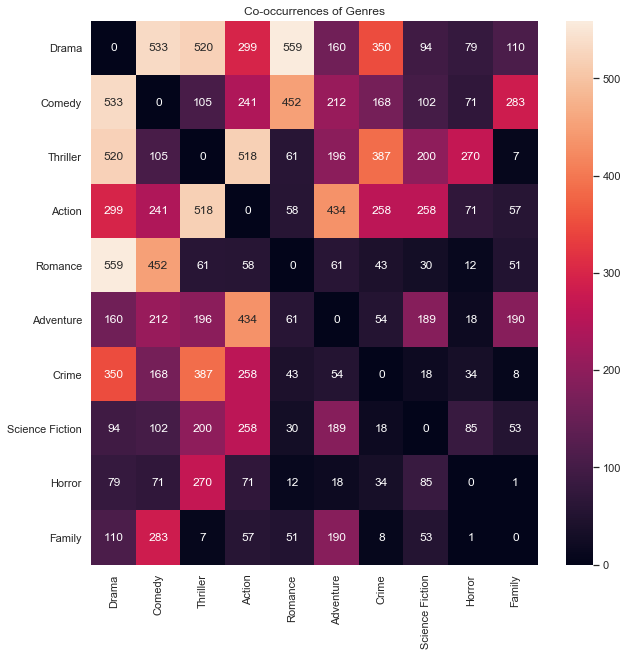

In [944]:
#Plotting the co-occurrence count between genres.
co_occur_df2=co_occur_df[[k for k in popular_genres]].loc[[k for k in popular_genres]]
f, ax = plt.subplots(figsize=(10, 10))                
sns.heatmap(co_occur_df2, annot=True, fmt='g').set_title("Co-occurrences of Genres")

#### What are the macro-trends in genre popularity over time?

Below we note the rise of Action and Adventure and Science Fiction, and to some extent, Family films.
This is at the expense of Drama, Comedy, Romance, and Thrillers, which had their peak in the Mid-1990s.

Text(0.5,1,'Trends in Genres By Year')

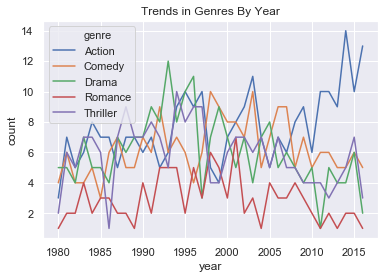

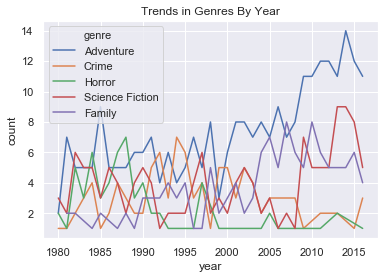

In [985]:
def distill_genre_count(ser):
    all_genres = [s for a in ser for s in a]
    return Counter(all_genres)

ss = success_analysis("profit", start_y=1980, end_y=2019)
ss = ss.groupby("title_year")["genres"].apply(lambda x: distill_genre_count(x))
ss = ss.reset_index()
ss = ss.rename(columns = {"level_1":"genre", "title_year":"year", "genres":"count"})
ss_ = ss[ss["genre"].isin(popular_genres[:5])]
f1, ax1 = plt.subplots()
sns.lineplot(x="year", y="count",
                 hue="genre", data=ss_).set_title("Trends in Genres By Year")

ss_ = ss[ss["genre"].isin(popular_genres[5:])]
f2, ax2 = plt.subplots()
sns.lineplot(x="year", y="count",
                 hue="genre", data=ss_).set_title("Trends in Genres By Year")

## Numeric Variables

#### Correlation between numeric variables

Text(0.5,1,'Correlations Between Outcome Variables')

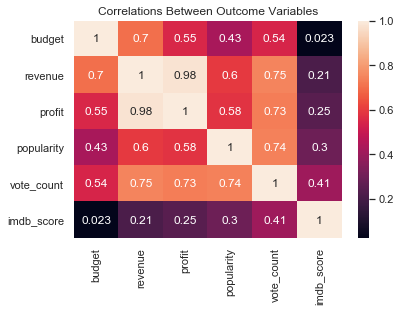

In [940]:
corr = m[numerics].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True,).set_title("Correlations Between Outcome Variables")

#### Descriptive statistics for Numeric Variables: Budget, Revenue, TMDB Popularity, Vote Count, Profit Margin

In [946]:
m[["budget", "revenue", "profit", "popularity", "vote_count","ret_rate"]].describe(percentiles=[.25, .5, .75, 0.9, 0.95, 0.99])

,budget,revenue,profit,popularity,vote_count,ret_rate
count,2907.00,2907.00,2907.00,2907.00,2907.00,2907.00
mean,43446932.83,128959111.68,85512178.85,30.18,1024.77,2.85
std,45064056.73,191646050.67,163054857.18,37.31,1449.38,6.68
min,1100000.00,7.00,-165710090.00,0.02,0.00,-1.00
25%,13000000.00,20234184.50,491619.50,11.25,201.00,0.03
50%,28000000.00,61399552.00,30565421.00,21.54,505.00,1.26
75%,60000000.00,154922186.50,103407932.00,38.21,1215.50,3.17
90%,100000000.00,327508607.80,242137713.80,61.22,2606.40,6.59
95%,145000000.00,491520794.80,398703894.10,81.70,4012.30,10.68
99%,200000000.00,926169209.48,782012196.92,139.04,7044.42,29.78


#### Scatterplot Analysis of Numeric Variables: Budget, Revenue, TMDB Popularity, IMDB Score

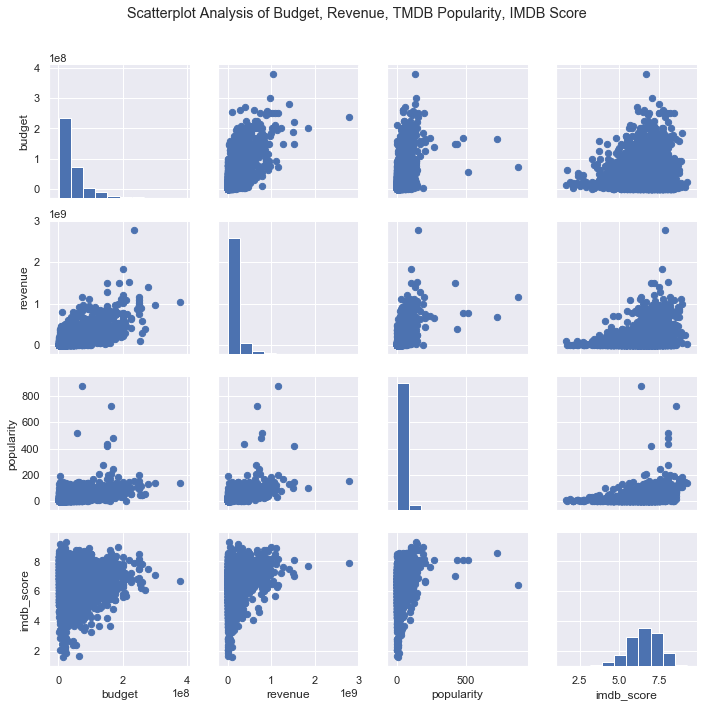

In [955]:
g = sns.PairGrid(m, x_vars=["budget", "revenue", "popularity", "imdb_score",],
                      y_vars=["budget", "revenue", "popularity", "imdb_score"])
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter, s =40)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Scatterplot Analysis of Budget, Revenue, TMDB Popularity, IMDB Score')
num_axes = len(g.axes)

#### Budget and Profit for the 30 Most Profitable Films

Text(0.5,1,'Budget and Profit for the 30 Most Profitable Films')

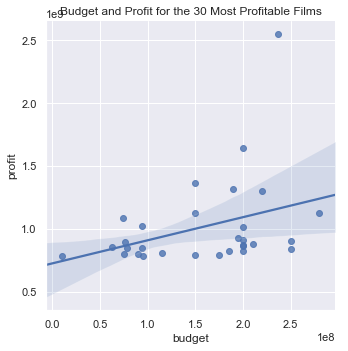

In [952]:
sns.lmplot(x = "budget", y = "profit", data = m.nlargest(30, "profit"))
axs = plt.gca()
axs.set_title("Budget and Profit for the 30 Most Profitable Films")

#### What Proportion of Films Are Unprofitable?

('Profitable', 703, 'Unprofitable', 2204)


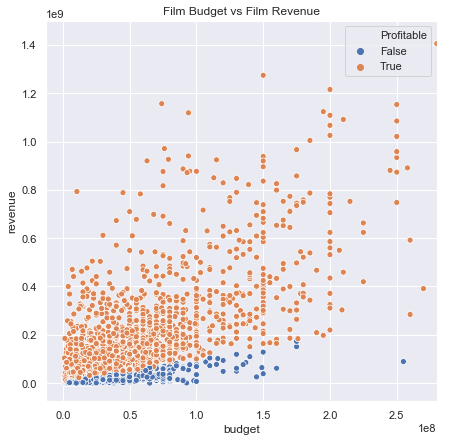

In [958]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xlim=(-0.125e8,2.8e8), ylim=(-0.075e9,1.5e9))
sns.scatterplot(x="budget", y="revenue", data=m,ci=75, hue="Profitable").set_title("Film Budget vs Film Revenue")
print("Profitable", len(m[m.Profitable == False]), "Unprofitable", len(m[m.Profitable == True]))

### Numeric Variables: Finding a Target Variable for Film Success

We wish to find a standardized way to measure the effect of budget on film financial success. Clearly budget and reveue are very highly correlated and values are also clustered, so it is hard to isolate effects. We look at log(budget) and log(revenue), and see that we obtain a nice linear relationship that islolates the effect much better.

Text(0.5,1.3,'Distribution of Log Budget and Log Revenue for All Films')

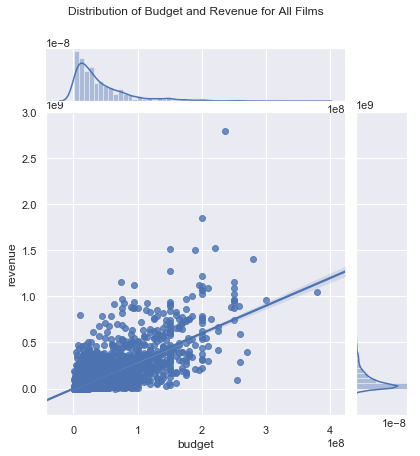

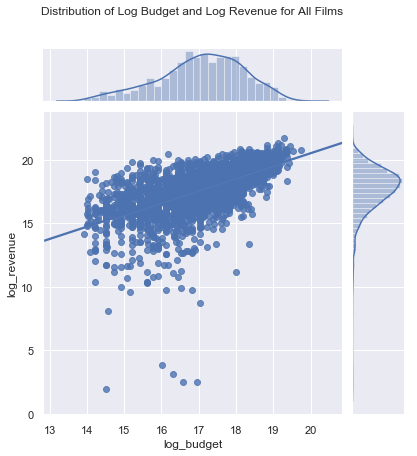

In [963]:
sns.jointplot(x="budget", y="revenue", data=m,ci=75, kind="reg")
plt.title("Distribution of Budget and Revenue for All Films", y=1.3)
sns.jointplot(x="log_budget", y="log_revenue", data=m,ci=30, kind="reg")
plt.title("Distribution of Log Budget and Log Revenue for All Films", y=1.3)

The fact that budget and revenue show a strong linear relationship seem to suggest that if we divide by budget (and get the profit margin, which we call here `rev_rate` "Revenue-Generating Rate"), we will obtain samples closer to statistical noise. This is a starting point to mine further information.

Text(0.5,1,'Log Budget vs Log Return Rate')

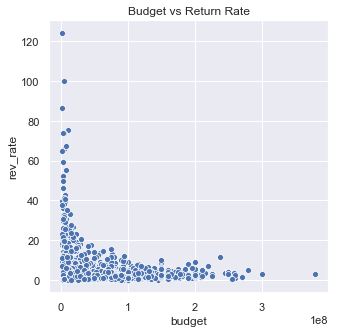

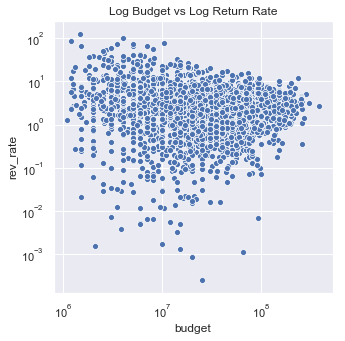

In [979]:
m_ = m
m_ = m_[m_.rev_rate > 1e-5]
f, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x=m_.budget, y=m_.rev_rate,ci=75).set_title("Budget vs Return Rate")
f, ax = plt.subplots(figsize=(5, 5))
ax.set(xscale="log", yscale="log")
sns.scatterplot(x=m_.budget, y=m_.rev_rate,ci=75).set_title("Log Budget vs Log Return Rate")

Aha! We have found that `log Profit Margin (log_rev_rate)` is highly uncorrelated with budget. If we are able to predict the value of `log Profit Margin` from previous factors, we will have learned something new!
We confirm this intuition computing the correlation between log_budget and log_rev_rate

In [966]:
m[["log_budget","log_rev_rate"]].corr()

,log_budget,log_rev_rate
log_budget,1.00,-0.03
log_rev_rate,-0.03,1.00


## Categorical Factors and Film Success

Now that we have found a meaningful metric for film success, we drill in deeper to find correlated factors amongst our other variables.
This section analyzes factors in film success by the categorical factors `genre`, `content rating`, `production company`, and `keywords`.
The analysis is continued further in "2. Factors in Film Success.ipynb".

In [ ]:
def expand_categorical(cat_var = "genres", filter_cat=None, top = None, by = "profit"):
    m_ = m
    if top is not None:
        m_ = success_analysis(measurement = by, top_no=top, start_y = 2000, end_y = 2019)
    m_expanded = m_[cat_var].apply(pd.Series)\
        .merge(m_,left_index=True, right_index=True)\
        .drop(cat_var, axis=1)
    m_expanded = m_expanded.melt(\
            id_vars = [a for a in m_expanded.columns if a not in range(0,7)],\
            value_name = cat_var)
    if filter_cat:
        m_expanded = m_expanded[m_expanded[cat_var].isin(filter_cat)]
    return m_expanded

def print_violinplots(col, filter_cat, target, filter_zero=False):
    num_cat = len(filter_cat)
    m_expanded = expand_categorical(col, filter_cat = filter_cat)
    if filter_zero:
        m_expanded = m_expanded[m_expanded[target] > 0]
    my_order = m_expanded.groupby(by=[col])[target].median().sort_values(ascending=False).index
    f, axs = plt.subplots(figsize=(8, num_cat / 3))
    axs = sns.violinplot(y=m_expanded[col], x=m_expanded[target], cut=1e9, order = my_order)
    
def print_content_rating_violinplot(target = 'profit', cut = 2, filter_zero=True):
    col, target = 'content_rating', target
    my_order = m.groupby(by=[col])[target].median().sort_values(ascending=False).index
    m_ = m
    if filter_zero:
        m_ = m_[ (m_[target] > 0) & (m_[target] is not None)]
    f, axs = plt.subplots(figsize=(6, 3))
    sns.violinplot(y=col, x=target, data=m_, order=my_order, cut = cut)

### The Most Successful Films By Year

Below, we plot the 20 most successful films by year according to various measures of success.

In [1003]:
def success_analysis(measurement = "profit", top_no=20, start_y = 2006, end_y = 2019):
    years = np.arange(start_y,end_y,1)
    m_ = m.dropna(subset=[measurement])
    best_profit = pd.concat([ m_[m_.title_year == y].nlargest(top_no, measurement) for y in years], axis=0)
    return best_profit, top_no

def plot_successful(measurement = "profit", label_no=10):
    best_profit, top_no = success_analysis(measurement)
    f, axs = plt.subplots(figsize=(8, 8))
    axs.scatter(best_profit.title_year, best_profit[measurement])
    axs.set_title("Top {} Films by {} by Year".format(top_no, measurement))
    top_n = best_profit.nlargest(label_no,measurement)
    top_n = top_n.reset_index()
    for i, txt in enumerate(top_n.original_title):
        axs.annotate(txt, (top_n.title_year[i], top_n[measurement][i]))

No film has been more profitable than Avatar in our dataset- not even close. Out of the other most profitable films of all time in our dataset, only a few truly break our and take off. Other successful films hover quite close to mean profit line.

2015 was truly a blockbuster year of blockbusters.

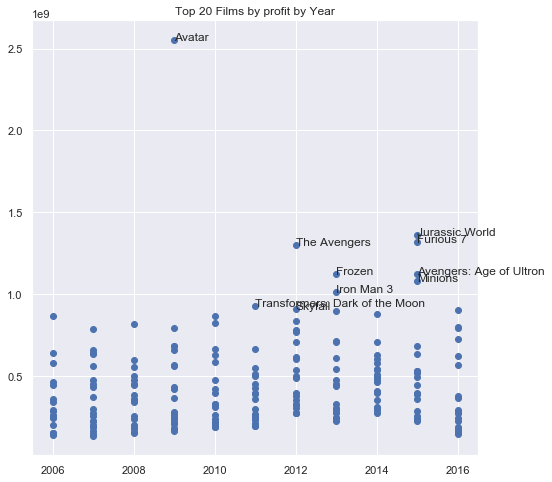

In [1004]:
plot_successful("profit", 10)
pass

Return rates for movies took a hard hit after the 2008 financial crisis. However, 2010 was truly a boom year for high-return movies. Return rates are coming back down again, perhaps signaling another bout of financial uncertainty in the film industry.

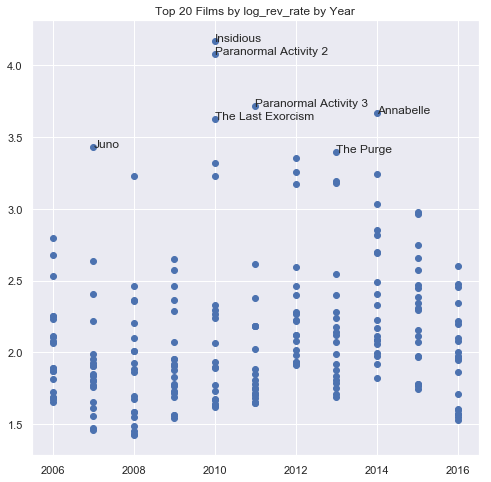

In [1005]:
plot_successful("log_rev_rate", 7)

TMDB popularity ratings are very heavily skewed towards newer films.

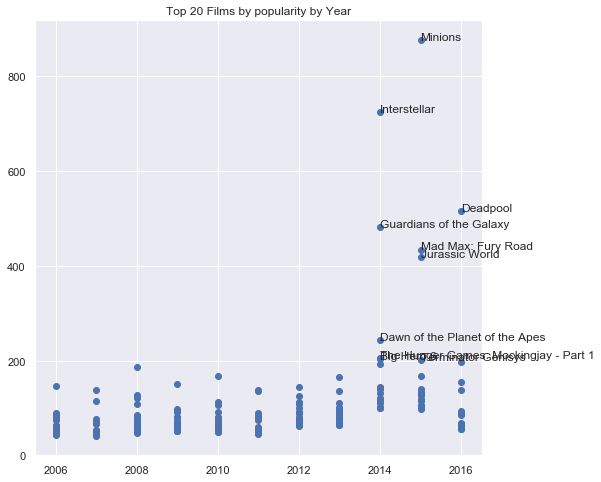

In [1006]:
plot_successful("popularity")

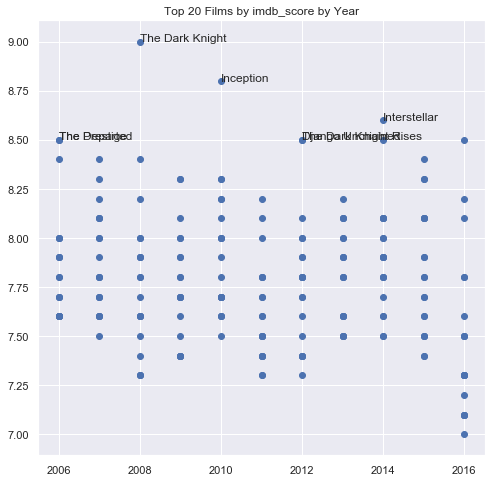

In [1007]:
plot_successful("imdb_score", 7)

Some movies are much more successful at using facebook than others.
Note that the trend of increased likes corresponds to an icrease in Facebook use. Facebook use seems to have been declining in the last three years.

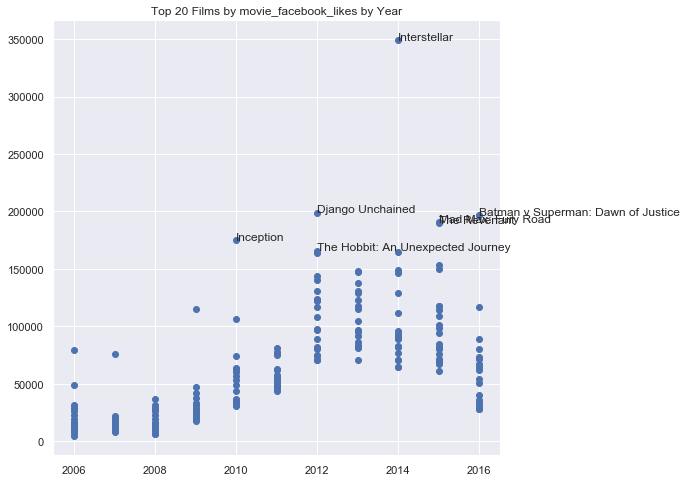

In [1008]:
plot_successful("movie_facebook_likes", 7)

This is not a measure of movie "success", rather, it plots how much money was spent on the most expensive movies by year. 2012 was a high point of movie spending.

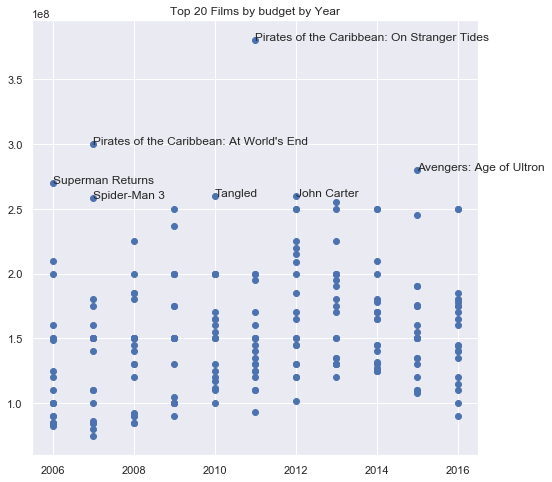

In [1012]:
plot_successful("budget", 7)

### Movie Success vs Budget by Genre

Here, we provide functionality to plot any movie's success as compared to its budget (or any other numeric variable), subsetting for genre. This function also allows for selection of the top_n nodes for any target variable.

In [1016]:
#The genres are provided as List[Category], we must first one-hot-encode them to make use of them
m_exp = m.copy()
m_exp = m_exp.join(pd.DataFrame(mlb.fit_transform(m.genres),columns = ["G_"+a for a in mlb.classes_],index=m.index))

In [1023]:
def plot_for_genres(m_exp, x_var = "budget",y_var = "profit", genres = None, top_no=None, xlim=None, ylim=None):
    if genres == None:
        genres = ['Drama','Comedy', 'Thriller', 'Action', 'Romance', 'Adventure', 'Crime','Science Fiction', 'Horror', 'Family']
    i=0
    for g in genres:
        g_name = "G_"+g
        filtered_df = m_exp[m_exp[g_name] == 1]
        scope = "All "
        if top_no is not None:
            filtered_df=filtered_df.nlargest(top_no,y_var)
            scope = "Top "+str(top_no)+" "
        f, axs = plt.subplots(figsize=(6,2))
        axs.set_title(x_var.capitalize()+" and "+y_var.capitalize()+" for "+scope+g+" Movies.")
        if xlim is not None and ylim is not None:
            axs.set(xlim=xlim, ylim=ylim)
        sns.regplot(ax=axs, x=x_var, y= y_var, data= filtered_df ,ci=75)
        i+=1
        

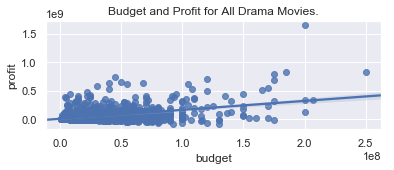

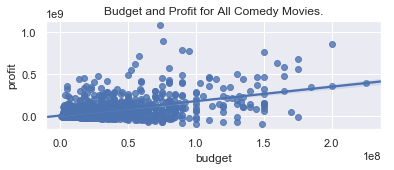

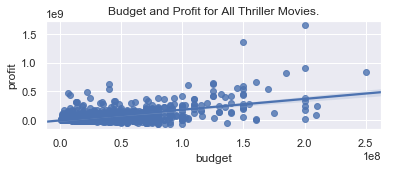

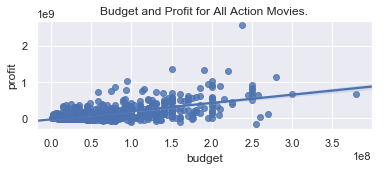

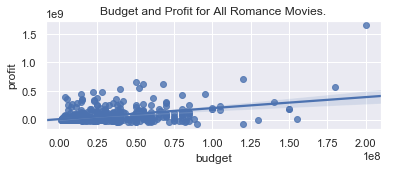

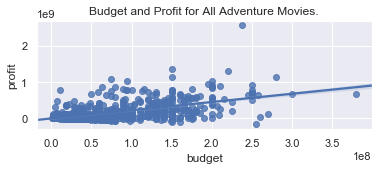

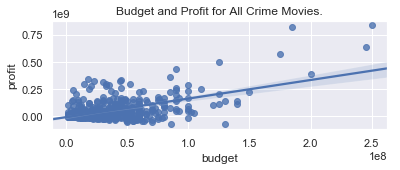

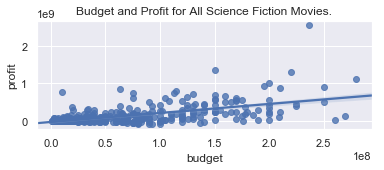

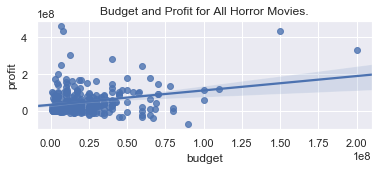

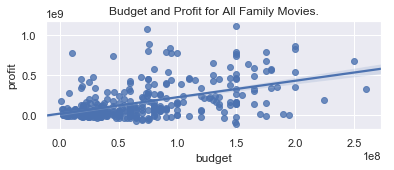

In [1024]:
plot_for_genres(m_exp, "budget", "profit", None)

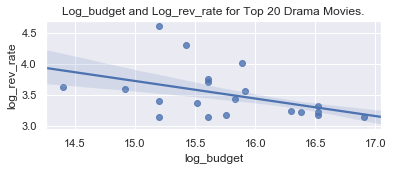

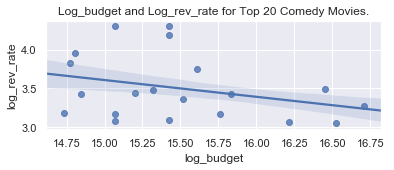

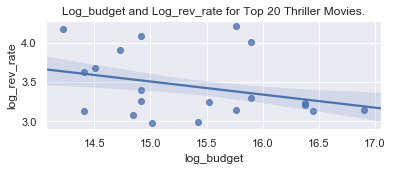

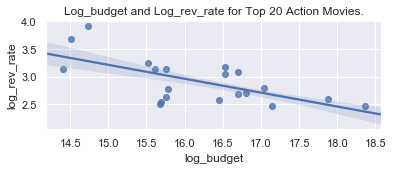

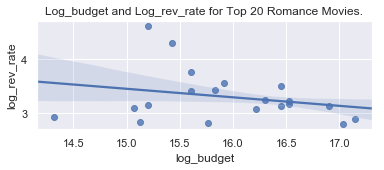

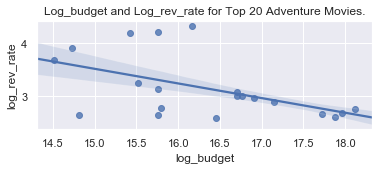

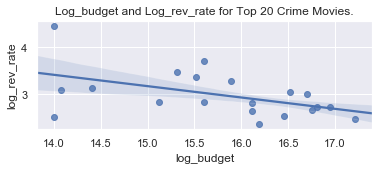

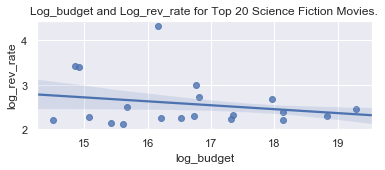

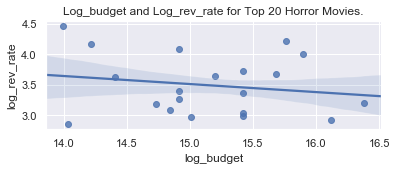

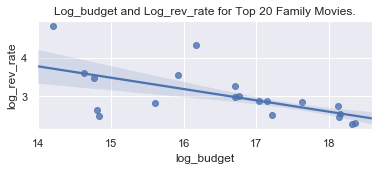

In [1026]:
plot_for_genres(m_exp, "log_budget", "log_rev_rate", top_no = 20)